In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed


from utils_functions import (
    avg_scores,
    train_and_score_model,
    print_scores
)


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, make_scorer

from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier

import lightgbm as lgb

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16 
plt.rcParams['axes.labelsize'] = 16

In [2]:
from imblearn.over_sampling import SMOTE 
from train_models import lightgbm_w_oversampling, _load_data

In [3]:
X, y = _load_data()

- # converged:  131385
- # not converged fragments:  441481
- ratio converged/total 0.229


In [4]:
with open("data/xtrain_smote.npy", "rb") as xtrain:
    Xres = np.load(xtrain).astype(np.int8)

with open("data/train_smote.npy", "rb") as ytrain:
    yres = np.load(ytrain).astype(np.int8)

In [9]:
len(np.where(y_res == 0)[0]), len(np.where(y_res == 1)[0])

(441481, 441481)

In [3]:
import rdkit
rdkit.__version__

'2021.03.5'

# Import data

In [10]:
with open("data/xtrain.npy", "rb") as ftrain:
    X = np.load(ftrain).astype(np.int8)

with open("data/ytrain.npy", "rb") as ytrain:
    y = np.load(ytrain).astype(np.int8)

In [11]:
print("- # converged: ", y.sum())
print("- # not converged fragments: ", len(np.where(y == 0)[0]))
print("- ratio converged/total {:.3f}".format( y.sum() / len(y)))

- # converged:  131385
- # not converged fragments:  441481
- ratio converged/total 0.229


# Train models - did fragment converge?

1 - did converge.
0 - didn't vonverge.

- fp (pred 1, should be 0) we compute on fragments that don't converge.
- fn (pred 0, should be 1) - these are bad. Eleminating frags that should not be.

In [13]:
scores = {
    "MCC": make_scorer(matthews_corrcoef),
    "ACC": make_scorer(accuracy_score),
    "confusion_matrix": make_scorer(confusion_matrix)
}

## Tree 

In [7]:
tree_clf = DecisionTreeClassifier(random_state=31)

tree_model = train_and_score_model(tree_clf, X, y, scores)
skf = StratifiedKFold(n_splits=2)
tree_cv_scores = [tree_model(*data_idx) for data_idx in skf.split(X, y)]

print_scores(tree_cv_scores)

RF(acc): 0.904 +/- 0.000
RF(mcc): 0.723 +/- 0.000

confusion_matrix mean
[[72.7331  4.3323]
 [ 5.3087 17.6259]]

confusion_matrix std
[[0.026  0.0258]
 [0.0185 0.0187]]

To compute: 21.96% of all
missing: 23.15 % of converged


## std RF

In [15]:
clf_rf = RandomForestClassifier(random_state=31, n_jobs=-1, n_estimators=10)
cv_rf_model = train_and_score_model(clf_rf, X_res, y_res, scores)

skf = StratifiedKFold(n_splits=2)
rf_cv_scores = [cv_rf_model(*data_idx) for data_idx in skf.split(X_res, y_res)]

print_scores(rf_cv_scores)

RF(acc): 0.945 +/- 0.012
RF(mcc): 0.891 +/- 0.025

confusion_matrix mean
[[46.9829  3.0171]
 [ 2.5069 47.4931]]

confusion_matrix std
[[0.5834 0.5833]
 [1.8204 1.8205]]

To compute: 50.51% of all
missing: 5.01 % of converged


##  RF w class weight ("oversampling")

In [ ]:
clf_rf_cw = RandomForestClassifier(random_state=31, class_weight={0: 1, 1: 1.5})
cv_rf_cw_model = train_and_score_model(clf_rf_cw, X, y, scores)

skf = StratifiedKFold(n_splits=n_splits)

rf_cw_cv_scores = Parallel(n_jobs=2)(
    delayed(cv_rf_cw_model)(*data_idx) for data_idx in skf.split(X, y)
)

print_scores(rf_cw_cv_scores)

## balanced RF - undersampling majority class

In [8]:
clf_balanced_rf = BalancedRandomForestClassifier(random_state=31, n_jobs=-1)
cv_balanced_rf_model = train_and_score_model(clf_balanced_rf, X, y, scores)

skf = StratifiedKFold(n_splits=2)
balanced_rf_cv_scores = [cv_balanced_rf_model(*data_idx) for data_idx in skf.split(X, y)]

print_scores(balanced_rf_cv_scores)

RF(acc): 0.895 +/- 0.000
RF(mcc): 0.741 +/- 0.000

confusion_matrix mean
[[68.4356  8.6298]
 [ 1.9029 21.0318]]

confusion_matrix std
[[0.0101 0.0103]
 [0.0019 0.0021]]

To compute: 29.66% of all
missing: 8.30 % of converged


## LightGBM

In [11]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
X_resampled.shape

(882962, 1024)

In [12]:
len(np.where(y_resampled == 0)[0]), len(np.where(y_resampled == 1)[0])

(441481, 441481)

In [16]:
lightgbm_model =  lgb.LGBMClassifier(objective='binary', random_state=31)
cv_lightgbm_model = train_and_score_model(lightgbm_model, X_res, y_res, scores)

skf = StratifiedKFold(n_splits=n_splits)
lightgbm_model_cv_scores = Parallel(n_jobs=1)( 
    delayed(cv_lightgbm_model)(*data_idx) for data_idx in skf.split(X_resampled, y_resampled)
)

print_scores(lightgbm_model_cv_scores)

NameError: name 'n_splits' is not defined

# Change cut-off from <0.5 .

In [31]:
def stats_cut(pred_prob):
    missing = []
    to_compute = []
    for cutoff in np.arange(0.0, 1.05, 0.05):
        pred = (pred_prob[:,1] > cutoff).astype(int)
        conf_matrix = confusion_matrix(ytest, pred)
        to_compute.append(sum(conf_matrix[:,1]) / sum(sum(conf_matrix)))
        
        missing.append(conf_matrix[1,0] / sum(conf_matrix[1,:]))
     
    return to_compute, missing

In [32]:
df_train, df_test = train_test_split(mopac_output_data, test_size=0.2, random_state=31)

Xtrain, ytrain = np.stack(df_train['ecfp_bits']), df_train['converged'].to_numpy().astype(int)
Xtest, ytest = np.stack(df_test['ecfp_bits']), df_test['converged'].to_numpy().astype(int)

In [33]:
# RF
rf_cutoff = RandomForestClassifier(n_estimators=100, random_state=31, n_jobs=5)
rf_cutoff.fit(Xtrain, ytrain)
pred_proba_rf = rf_cutoff.predict_proba(Xtest) 

In [34]:
# RF CW
rf_cw_cutoff = RandomForestClassifier(n_estimators=100, n_jobs=5, random_state=31, class_weight={0: 1, 1: 1.5})
rf_cw_cutoff.fit(Xtrain, ytrain)
pred_proba_rf_cw = rf_cw_cutoff.predict_proba(Xtest) 

In [35]:
# Balanced RF
balanced_rf_cutoff = BalancedRandomForestClassifier(n_estimators=100, random_state=31, n_jobs=5)
balanced_rf_cutoff.fit(Xtrain, ytrain)
pred_proba_balanced = balanced_rf_cutoff.predict_proba(Xtest) 

[Text(0.5, 0, 'Model predicted probability')]

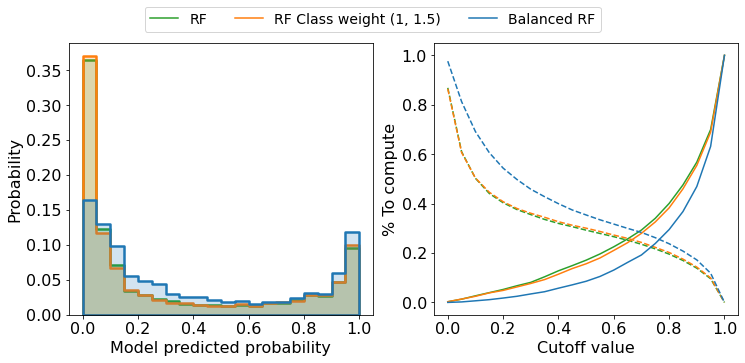

In [36]:
# Get statys
rf_compute, rf_missing = stats_cut(pred_proba_rf)
rfCW_compute, rfCW_missing = stats_cut(pred_proba_rf_cw)
rfBalanced_compute, rfBalanced_missing = stats_cut(pred_proba_balanced)


# plot
fig_cutoff, ax_cutoff = plt.subplots(figsize=(12, 5), ncols=2)


ax_cutoff[1].plot(np.arange(0, 1.05, 0.05), rf_missing, 'tab:green', label='RF')
ax_cutoff[1].plot(np.arange(0, 1.05, 0.05), rf_compute, 'tab:green', linestyle='--') 
sns.histplot(pred_proba_rf[:,1], bins=20, stat='probability', ax=ax_cutoff[0], color='tab:green',  element="step",  alpha=0.2, linewidth = 2.5)

ax_cutoff[1].plot(np.arange(0, 1.05, 0.05), rfCW_missing, 'tab:orange', label='RF Class weight (1, 1.5)')
ax_cutoff[1].plot(np.arange(0, 1.05, 0.05), rfCW_compute, 'tab:orange', linestyle='--')
sns.histplot(pred_proba_rf_cw[:,1], bins=20, stat='probability', ax=ax_cutoff[0],   color='tab:orange', element="step",  alpha=0.2, linewidth = 2.5)

ax_cutoff[1].plot(np.arange(0, 1.05, 0.05), rfBalanced_missing, 'tab:blue', label='Balanced RF')
ax_cutoff[1].plot(np.arange(0, 1.05, 0.05), rfBalanced_compute, 'tab:blue', linestyle='--')
sns.histplot(pred_proba_balanced[:,1], bins=20, stat='probability', ax=ax_cutoff[0],   color='tab:blue', element="step",  alpha=0.2, linewidth = 2.5)


fig_cutoff.legend(fontsize=14, loc='upper center', ncol=3)
ax_cutoff[1].set(xlabel='Cutoff value', ylabel='% To compute')
ax_cutoff[0].set(xlabel='Model predicted probability')

## Check very wrong componds

In [45]:
pred = (pred_proba_balanced[:,1] > 0.2).astype(int)
confusion_matrix(ytest, pred)

array([[12028,  6236],
       [  150,  8275]])

In [46]:
very_wrong_idx = np.where((pred - ytest == -1).astype(int) == 1)
very_wrong_idx

(array([  128,   239,   423,   531,   656,   934,   972,  1347,  1566,
         1791,  1868,  1893,  1999,  2064,  2177,  2399,  2613,  2895,
         2902,  3835,  4336,  4359,  4911,  5161,  5622,  5712,  6012,
         6211,  6276,  6454,  6938,  7242,  7560,  7642,  7738,  7768,
         7799,  8360,  8540,  8676,  8785,  9144,  9250,  9433,  9472,
         9739,  9837, 10103, 10175, 10239, 10241, 10400, 10588, 10599,
        10794, 11249, 11319, 11973, 12109, 12354, 12424, 12731, 12877,
        13083, 13645, 13847, 14002, 14307, 14323, 14527, 14696, 14720,
        14887, 15156, 15175, 15579, 15935, 16047, 16531, 16751, 16825,
        16843, 16880, 16954, 17041, 17048, 17217, 17223, 17297, 17327,
        17494, 17654, 17821, 17829, 17920, 17925, 18296, 18447, 18730,
        18829, 19494, 19870, 20059, 20430, 20589, 20683, 20722, 20792,
        20821, 20831, 20856, 20896, 20977, 21024, 21498, 21572, 21694,
        22355, 22512, 22533, 22721, 22815, 22841, 22884, 23309, 23587,
      

,frag_smiles,nconfs,nconv_confs,enthalpy,converged,molobj,ecfp_bits,bit_info,new_conv
104656,[H][C-]=C1C([H])([H])[O+](C([H])([H])[H])C1([H...,4,1,[118.40708],True,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{24: ((6, 0),), 235: ((7, 1),), 257: ((0, 1),)...",False
34106,[H]OC1([C+]([H])[H])C([H])([H])[C-]([H])C1([H]...,7,1,[75.56295],True,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{333: ((9, 0),), 381: ((3, 0),), 412: ((9, 1),...",False
13578,[H][N]1[C-]2[O+]([H])N=C(C([H])([H])[H])[C@@]2...,4,1,[104.01351],True,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{24: ((3, 0),), 30: ((5, 2),), 88: ((11, 2),),...",False
11396,[H][O+]([H])[C@]12C([H])([H])[C@@]1([H])C2([H]...,4,4,"[76.04902, 76.03851, 76.07955, 76.03945]",True,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{50: ((1, 1),), 361: ((3, 2),), 541: ((0, 1), ...",True
87583,[H]C1([H])[C-]2[C@@]3([H])[C@@]4([H])[C@]1([H]...,1,1,[144.88099],True,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{333: ((3, 0),), 661: ((12, 2),), 738: ((4, 2)...",True
...,...,...,...,...,...,...,...,...,...
131975,[H][C-]1[C@]2([H])[C@@]3([H])[C@]4([H])[C@@]3(...,1,1,[173.59304],True,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{129: ((6, 2),), 333: ((1, 0),), 800: ((1, 1),...",True
57298,[H]C1=N[C-]2[C@]1([H])O[N+]2([H])[H],1,1,[123.74731],True,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{176: ((0, 1),), 187: ((3, 1),), 235: ((4, 1),...",True
82629,[H]/[C-]=C1/C([H])=C([H])[O+]([H])C1([H])[H],1,1,[119.6034],True,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{24: ((7, 0),), 54: ((3, 1),), 176: ((4, 1), (...",True
47351,[H]C[O+]([H])[C+]([H])[C-]([O-])C([H])([H])[H],13,1,[74.96297],True,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{116: ((6, 2),), 324: ((6, 1),), 381: ((4, 0),...",False

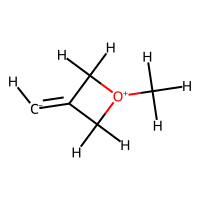
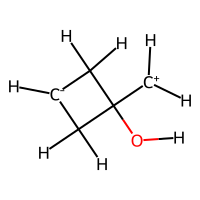
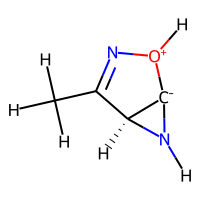
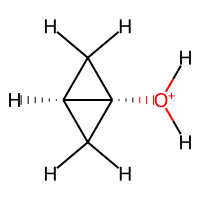
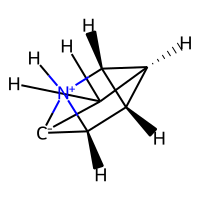
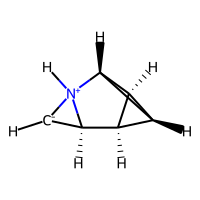
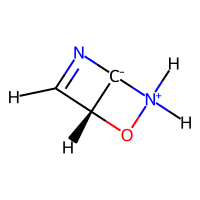
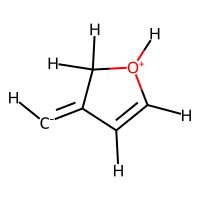
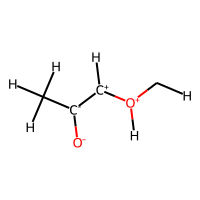
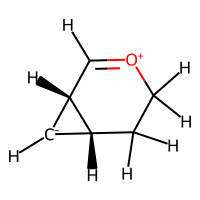

In [47]:
very_wrong_mols = df_test.iloc[very_wrong_idx]
very_wrong_mols

In [48]:
vX = np.zeros((len(very_wrong_mols), len(very_wrong_mols.iloc[0].ecfp_bits)))
for i, bits in enumerate(very_wrong_mols.ecfp_bits):
    vX[i] = bits

balanced_rf_cutoff.predict(vX)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

The model is very certian that the 55 mols won't converge. However, they did. 
How do the ones that the model miss correlate with reaction energy.

# Train Model

In [6]:
import pickle

In [8]:
true_model = BalancedRandomForestClassifier(random_state=31, n_jobs=-1)
true_model.fit(X, y)

BalancedRandomForestClassifier(n_jobs=-1, random_state=31)

In [9]:
pickle.dump(true_model, open("models/balanced_convergence_clf.pkl", 'wb'))

In [5]:
clf_rf = RandomForestClassifier(random_state=31, n_jobs=-1, verbose=5)
clf_rf.fit(Xres, yres)
pickle.dump(clf_rf, open("models/rd_smote_convergence_clf.pkl", 'wb'))
#cv_rf_model = train_and_score_model(clf_rf, X_res, y_res, scores)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100building tree 8 of 100

building tree 9 of 100
building tree 10 of 100
building tree 11 of 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   39.3s


building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.0min


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.6min finished


NameError: name 'pickle' is not defined

In [7]:
pickle.dump(clf_rf, open("models/rf_smote_convergence_clf.pkl", 'wb'))

In [10]:
clf_rf.fit(Xres, yres)
pickle.dump(true_model, open("models/rd_smote_convergence_clf.pkl", 'wb'))

# Explain Bits

In [1]:
#Chem.Draw.DrawMorganBit(test_mol.molobj, 1986, test_mol.bit_info, useSVG=True)

In [ ]:
# how does theese correlate with the reaction energy. 

# TODO: I need to compute the reactant energy the reactions i have used.
# Try just one desiccion tree.